In [1]:
import os
from os.path import exists

import anchor
import anchor.anchor_tabular

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import uniform, randint
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error

from sklearn.svm import SVC
from sklearn.base import BaseEstimator, ClassifierMixin

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import joblib
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, f1_score, recall_score
from sklearn.inspection import DecisionBoundaryDisplay


import operator as op
from AnchorGeneration import *


In [3]:
data_path = "simulationVictor/"
res_path = data_path+"resultsPSR_Safe/"
results_anchorfile = "anchors-csr.csv"
feature_labels = ["SafetyMargin","Eta","Tau"]
true_output = "y_true"
cp_output = "y_conformal"
#model_output = "y_pred"

rules = pd.read_csv(res_path+results_anchorfile)

model = joblib.load(data_path+"CP_SVM_safe.sav")

test = pd.read_csv(data_path+"test_cp.csv")
y_test = np.array(test[true_output])
#y_model_test = np.array(test[model_output])
y_cp_test = np.array(test[cp_output])
X_test_df = test.drop([true_output,cp_output],axis = 1)
X_test = np.array(X_test_df)

In [4]:
test.describe()

,SafetyMargin,Eta,Tau,y_true,y_conformal
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.051640,0.501391,0.501864,0.096000,0.076000
std,0.028232,0.291426,0.288480,0.995879,0.997607
min,0.000036,0.001484,0.001992,-1.000000,-1.000000
25%,0.027881,0.248668,0.262494,-1.000000,-1.000000
50%,0.051710,0.485138,0.490627,1.000000,1.000000
75%,0.074998,0.762230,0.756724,1.000000,1.000000
max,0.099896,0.998724,0.998572,1.000000,1.000000


In [5]:
# visualize the anchors for all test set
rules

,Index,AnchorConditions,Coverage,Precision,AnchorOutput,ModelOutput,RealOutput
0,0,Tau <= 0.51,0.4944,0.772553,1.0,1.0,1.0
1,1,Tau <= 0.25,0.2417,0.876168,1.0,1.0,1.0
2,2,Tau <= 0.25,0.2474,0.874251,1.0,1.0,1.0
3,3,SafetyMargin <= 0.02,0.2528,0.799273,-1.0,-1.0,-1.0
4,4,SafetyMargin > 0.08,0.2491,0.841981,1.0,1.0,1.0
...,...,...,...,...,...,...,...
976,995,Tau <= 0.51,0.4978,0.750801,1.0,1.0,1.0
977,996,Tau <= 0.25,0.2511,0.900929,1.0,1.0,1.0
978,997,SafetyMargin <= 0.05,0.4929,0.707539,-1.0,-1.0,1.0
979,998,SafetyMargin <= 0.05,0.5026,0.706078,-1.0,-1.0,1.0


In [6]:
rules[rules["AnchorOutput"]==1]["AnchorConditions"].value_counts()

AnchorConditions
Tau <= 0.25            207
SafetyMargin > 0.08    145
Tau <= 0.51             94
SafetyMargin > 0.05     60
Eta > 0.74              10
Eta > 0.50               4
Name: count, dtype: int64

In [7]:
model.get_params()

{'alpha': array([-3.60960298e-05, -5.94496368e-06,  4.99781884e-01, ...,
         4.99959117e-01, -3.87267241e-05,  5.00202682e-01]),
 'b': array([-0.12019627]),
 'b_eps': 0.16828101780637864,
 'eta': 0.3,
 'kernel': 'polynomial',
 'param': 3,
 'tau': array([[0.5]]),
 'solver': 'osqp'}

# Candidate selection

Text(0, 0.5, 'Count')

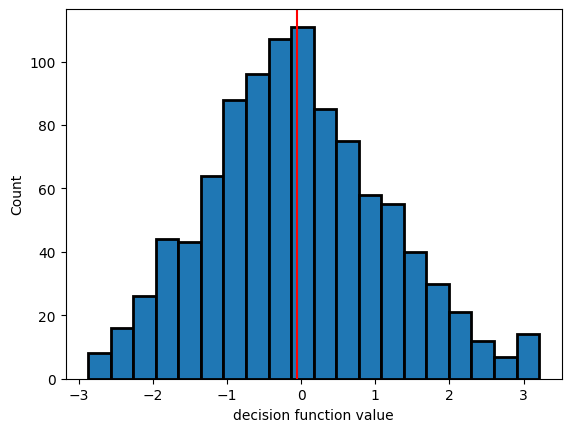

In [8]:
# distances of test points from decision boundary
d_test = model.decision_function(X_test)

plt.hist(d_test,bins = 20, edgecolor = "black",linewidth=2)
plt.gca().axvline(x=-0.05, color = "red")
plt.xlabel("decision function value")
plt.ylabel("Count")

In [9]:
min(d_test)

-2.8732184986121783

In [10]:
max(d_test)

3.2099046626753673

In [11]:
model.b_eps

0.16828101780637864

In [12]:
d_thresh = 0.05

border_points_idx = np.where((d_test < 0) & (abs(d_test) < d_thresh) & (y_cp_test == 1))[0]

print(f"# of candidate points: {len(border_points_idx)}")

# of candidate points: 19


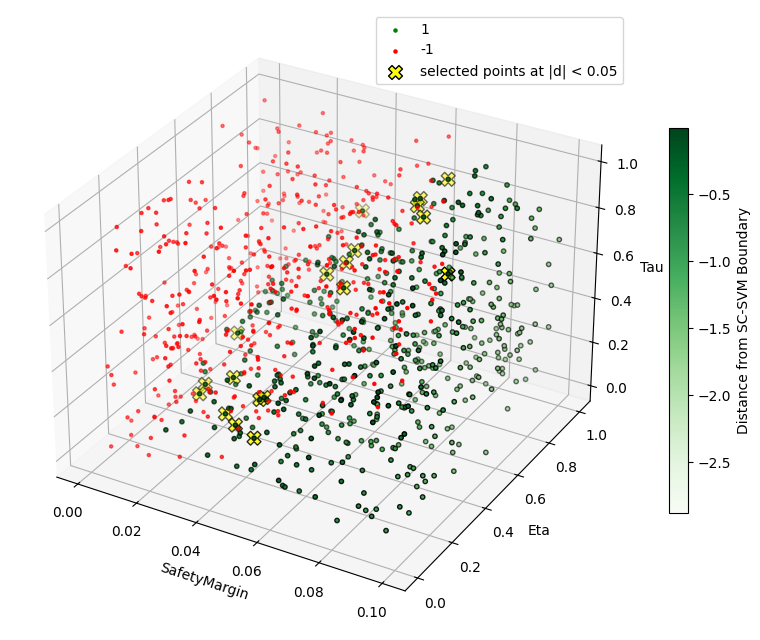

In [13]:
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(projection='3d')

sc0 = ax.scatter3D(X_test[:,0][y_cp_test == -1], X_test[:,1][y_cp_test == -1], X_test[:,2][y_cp_test == -1], s=5, c= "red")
scsafe = ax.scatter3D(X_test[:,0][y_cp_test == 1], X_test[:,1][y_cp_test == 1], X_test[:,2][y_cp_test == 1], s=5, c= "green")

sc1 = ax.scatter3D(X_test[:,0][y_cp_test == 1], X_test[:,1][y_cp_test == 1], X_test[:,2][y_cp_test == 1], s=10, c=d_test[y_cp_test == 1], cmap = "Greens", edgecolors = "k")

sc2 = ax.scatter3D(X_test[list(border_points_idx),0],X_test[list(border_points_idx),1], X_test[list(border_points_idx),2],s=100, marker = 'X', facecolors="yellow", edgecolors="k")


ax.set_xlabel("SafetyMargin")
ax.set_ylabel("Eta")
ax.set_zlabel("Tau")



ax.legend([scsafe, sc0,sc2], ["1","-1",f"selected points at |d| < {d_thresh}"], loc="upper right")
plt.colorbar(sc1, label = "Distance from SC-SVM Boundary", shrink = 0.5)

plt.show()

# Select the anchors for the candidate points

In [14]:
rule_cand_idx = np.array(rules[rules["Index"].isin(border_points_idx)==True].index)

In [15]:
# get rules generated on the selected boundary points
rules_candidates = rules.iloc[rule_cand_idx,:]

In [17]:
# focus on non collision class (label +1)
rules_noncoll = rules_candidates[rules_candidates["AnchorOutput"] == 1]
# '''
# # define a threshold for filtering on covering
# covering_threshold = 0.1

# rules_selected = rules_noncoll[rules_noncoll["Coverage"]>= covering_threshold]

# rules_selected = rules_selected.sort_values(by = ["Coverage"], axis = 0, ascending = False)

# rules_selected
# '''

In [18]:
rules_noncoll["AnchorConditions"].value_counts()

AnchorConditions
SafetyMargin > 0.05    5
Tau <= 0.51            5
Tau <= 0.25            4
Eta > 0.50             3
Eta > 0.74             1
SafetyMargin > 0.08    1
Name: count, dtype: int64

# Performance Evaluation


In [19]:
def evaluate_rules(data, tuned_rules, output):
    predictions_all = []
    for i, rule in tuned_rules.iterrows():
        pred_rule = []
        tptot = 0
        tntot = 0
        fntot = 0
        fptot = 0
        tuned_antecedent = rule['AnchorConditions'].strip()
        print(f"rule: {tuned_antecedent}")
        for _, row in data.iterrows():
            y_row = row[output]
            tp = 0
            tn = 0
            fn = 0
            fp = 0
            # check if the point row satifies rule 
            if evaluate_rule_conditions(row, tuned_antecedent):
                # rule is satisfied
                satisfied = True
                pred_rule.append(1)
            else:
                satisfied = False
                pred_rule.append(-1)
    
            
            if satisfied and y_row == 1:
                tp=1
            elif satisfied and y_row == -1:
                fp=1
            elif not satisfied and y_row == -1:
                tn=1
            
            elif not satisfied and y_row == 1:
                fn=1
            predictions_all.append(pred_rule)
            tptot+=tp
            tntot+=tn
            fptot+=fp
            fntot+=fn

        
        print(f"tp = {tptot}, tn = {tntot}, fp = {fptot}, fn = {fntot}")
        prec = tptot / (tptot+fptot)
        cov = tptot/(tptot+fntot)
        acc = (tptot+tntot)/(tptot+tntot+fptot+fntot)
        f1score = (2*tptot)/(2*tptot+fptot+fntot)
        err = fptot/(tntot+fptot)
        print(f"precision: {prec}, covering: {cov}, error: {err}, accuracy: {acc}, f1: {f1score}\n")          

    return predictions_all


def evaluate_rule_conditions(row, condition_part):

    # Checks if any of the conditions in the rule are satisfied
    if all(check_condition(row, part) for part in condition_part.split(" AND ")):
        return True  # Return True if all conditions in the rule are satisfied
    
    return False  # Return False if any of the conditions in the rule is not satisfied


def check_condition(row, condition_part):
    # Check if a single condition part is satisfied
    
    parts = [part.strip('()') for part in condition_part.split()]
    #print("parts: ", parts)
    if len(parts) == 3:
        column, op, value = parts
        return eval(f"{row[column]} {op} {value}")
    # handle the case of a 2-thresholds conditions of the kind: a < Column <= b
    elif len(parts) == 5:
        val1,op1,column,op2,val2 = parts
        # Use the original condition from the rule
        return eval(f"{val1} {op1} {row[column]} {op2} {val2}")        
    else:
        # Handle cases where the condition is not in the expected format
        pass

# SafetyMargin > 0.05 AND Tau <= 0.25 AND Eta > 0.25


In [20]:
rules_noncoll_unique = rules_noncoll.drop_duplicates(subset = "AnchorConditions")
rules_noncoll_unique

,Index,AnchorConditions,Coverage,Precision,AnchorOutput,ModelOutput,RealOutput
141,141,Tau <= 0.25,0.2519,0.893688,1.0,1.0,-1.0
143,143,SafetyMargin > 0.05,0.5025,0.775564,1.0,1.0,1.0
223,225,Eta > 0.74,0.2456,0.688729,1.0,1.0,1.0
240,242,Tau <= 0.51,0.5038,0.743142,1.0,1.0,1.0
252,254,Eta > 0.50,0.5018,0.657955,1.0,1.0,1.0
955,973,SafetyMargin > 0.08,0.2496,0.865625,1.0,1.0,1.0


# Evaluation on true labels

In [21]:
preds_by_rule = evaluate_rules(test, rules_noncoll_unique, true_output)

rule: Tau <= 0.25
tp = 187, tn = 398, fp = 54, fn = 361
precision: 0.7759336099585062, covering: 0.34124087591240876, error: 0.11946902654867257, accuracy: 0.585, f1: 0.4740177439797212

rule: SafetyMargin > 0.05
tp = 412, tn = 343, fp = 109, fn = 136
precision: 0.7907869481765835, covering: 0.7518248175182481, error: 0.2411504424778761, accuracy: 0.755, f1: 0.7708138447146866

rule: Eta > 0.74
tp = 194, tn = 371, fp = 81, fn = 354
precision: 0.7054545454545454, covering: 0.354014598540146, error: 0.17920353982300885, accuracy: 0.565, f1: 0.47144592952612396

rule: Tau <= 0.51
tp = 363, tn = 301, fp = 151, fn = 185
precision: 0.7062256809338522, covering: 0.6624087591240876, error: 0.334070796460177, accuracy: 0.664, f1: 0.6836158192090396

rule: Eta > 0.50
tp = 324, tn = 288, fp = 164, fn = 224
precision: 0.6639344262295082, covering: 0.5912408759124088, error: 0.36283185840707965, accuracy: 0.612, f1: 0.6254826254826255

rule: SafetyMargin > 0.08
tp = 179, tn = 425, fp = 27, fn = 369

# evaluation on safety checker labels

In [22]:
preds_by_rule_cp = evaluate_rules(test, rules_noncoll_unique, cp_output)

rule: Tau <= 0.25
tp = 215, tn = 436, fp = 26, fn = 323
precision: 0.8921161825726142, covering: 0.3996282527881041, error: 0.05627705627705628, accuracy: 0.651, f1: 0.55198973042362

rule: SafetyMargin > 0.05
tp = 395, tn = 336, fp = 126, fn = 143
precision: 0.7581573896353166, covering: 0.7342007434944238, error: 0.2727272727272727, accuracy: 0.731, f1: 0.7459867799811143

rule: Eta > 0.74
tp = 200, tn = 387, fp = 75, fn = 338
precision: 0.7272727272727273, covering: 0.37174721189591076, error: 0.16233766233766234, accuracy: 0.587, f1: 0.4920049200492005

rule: Tau <= 0.51
tp = 384, tn = 332, fp = 130, fn = 154
precision: 0.7470817120622568, covering: 0.7137546468401487, error: 0.2813852813852814, accuracy: 0.716, f1: 0.7300380228136882

rule: Eta > 0.50
tp = 334, tn = 308, fp = 154, fn = 204
precision: 0.6844262295081968, covering: 0.620817843866171, error: 0.3333333333333333, accuracy: 0.642, f1: 0.6510721247563352

rule: SafetyMargin > 0.08
tp = 176, tn = 432, fp = 30, fn = 362
pr

**Evaluate the $\lor$ of the rules**

In [26]:
verified1 = (X_test[:,0] > 0.07) 

verified2 = (X_test[:,2] <= 0.25) 

verified_or = verified1|verified2

prec, cov, acc, fscore,err = ComputeMetricsForRule(verified_or, y_cp_test)
print(f"precision: {prec}, covering: {cov}, accuracy: {acc}, f1: {fscore}, error: {err}")  

tp = 400, tn = 379, fp = 83, fn = 138
precision: 0.8281573498964804, covering: 0.7434944237918215, accuracy: 0.779, f1: 0.7835455435847208, error: 0.17184265010351968
